In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Display configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

In [4]:
# Check missing values
print("=" * 50)
print("MISSING VALUES")
print("=" * 50)
missing = train_df.isnull().sum()
missing_percent = 100 * train_df.isnull().sum() / len(train_df)
missing_table = pd.concat([missing, missing_percent], axis=1)
missing_table.columns = ['Missing Values', 'Percentage (%)']
missing_table = missing_table[missing_table['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
print(missing_table)

MISSING VALUES
          Missing Values  Percentage (%)
Cabin                687       77.104377
Age                  177       19.865320
Embarked               2        0.224467


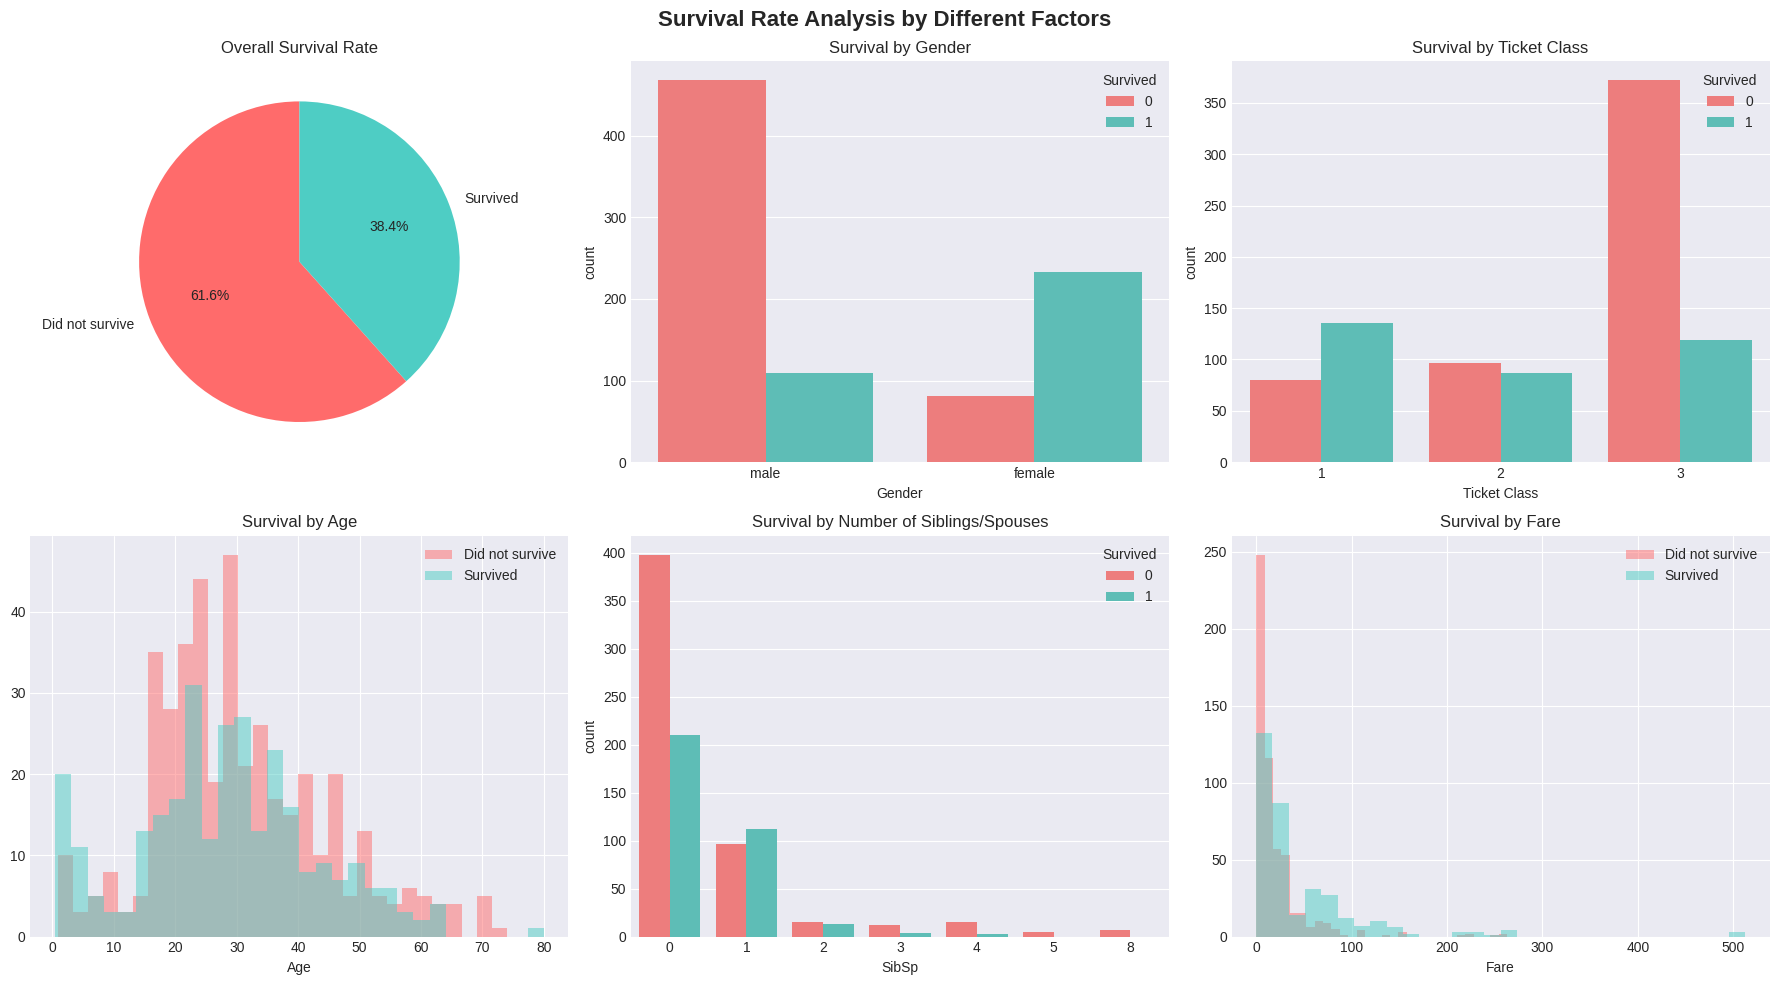

In [5]:
# Visualize survival rates
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Survival Rate Analysis by Different Factors', fontsize=16, fontweight='bold')

# 1. Overall survival rate
if 'survived' in train_df.columns:
    survived_col = 'survived'
elif 'Survived' in train_df.columns:
    survived_col = 'Survived'
    
survived_counts = train_df[survived_col].value_counts()
axes[0, 0].pie(survived_counts, labels=['Did not survive', 'Survived'], autopct='%1.1f%%', startangle=90, colors=['#ff6b6b', '#4ecdc4'])
axes[0, 0].set_title('Overall Survival Rate')

# 2. By gender
sex_col = 'sex' if 'sex' in train_df.columns else 'Sex'
sns.countplot(data=train_df, x=sex_col, hue=survived_col, ax=axes[0, 1], palette=['#ff6b6b', '#4ecdc4'])
axes[0, 1].set_title('Survival by Gender')
axes[0, 1].set_xlabel('Gender')

# 3. By ticket class
pclass_col = 'pclass' if 'pclass' in train_df.columns else 'Pclass'
sns.countplot(data=train_df, x=pclass_col, hue=survived_col, ax=axes[0, 2], palette=['#ff6b6b', '#4ecdc4'])
axes[0, 2].set_title('Survival by Ticket Class')
axes[0, 2].set_xlabel('Ticket Class')

# 4. By age
age_col = 'age' if 'age' in train_df.columns else 'Age'
train_df[train_df[survived_col] == 0][age_col].hist(bins=30, alpha=0.5, label='Did not survive', ax=axes[1, 0], color='#ff6b6b')
train_df[train_df[survived_col] == 1][age_col].hist(bins=30, alpha=0.5, label='Survived', ax=axes[1, 0], color='#4ecdc4')
axes[1, 0].set_title('Survival by Age')
axes[1, 0].set_xlabel('Age')
axes[1, 0].legend()

# 5. By number of siblings/spouses
sibsp_col = 'sibsp' if 'sibsp' in train_df.columns else 'SibSp'
sns.countplot(data=train_df, x=sibsp_col, hue=survived_col, ax=axes[1, 1], palette=['#ff6b6b', '#4ecdc4'])
axes[1, 1].set_title('Survival by Number of Siblings/Spouses')
axes[1, 1].set_xlabel('SibSp')

# 6. By fare
fare_col = 'fare' if 'fare' in train_df.columns else 'Fare'
train_df[train_df[survived_col] == 0][fare_col].hist(bins=30, alpha=0.5, label='Did not survive', ax=axes[1, 2], color='#ff6b6b')
train_df[train_df[survived_col] == 1][fare_col].hist(bins=30, alpha=0.5, label='Survived', ax=axes[1, 2], color='#4ecdc4')
axes[1, 2].set_title('Survival by Fare')
axes[1, 2].set_xlabel('Fare')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

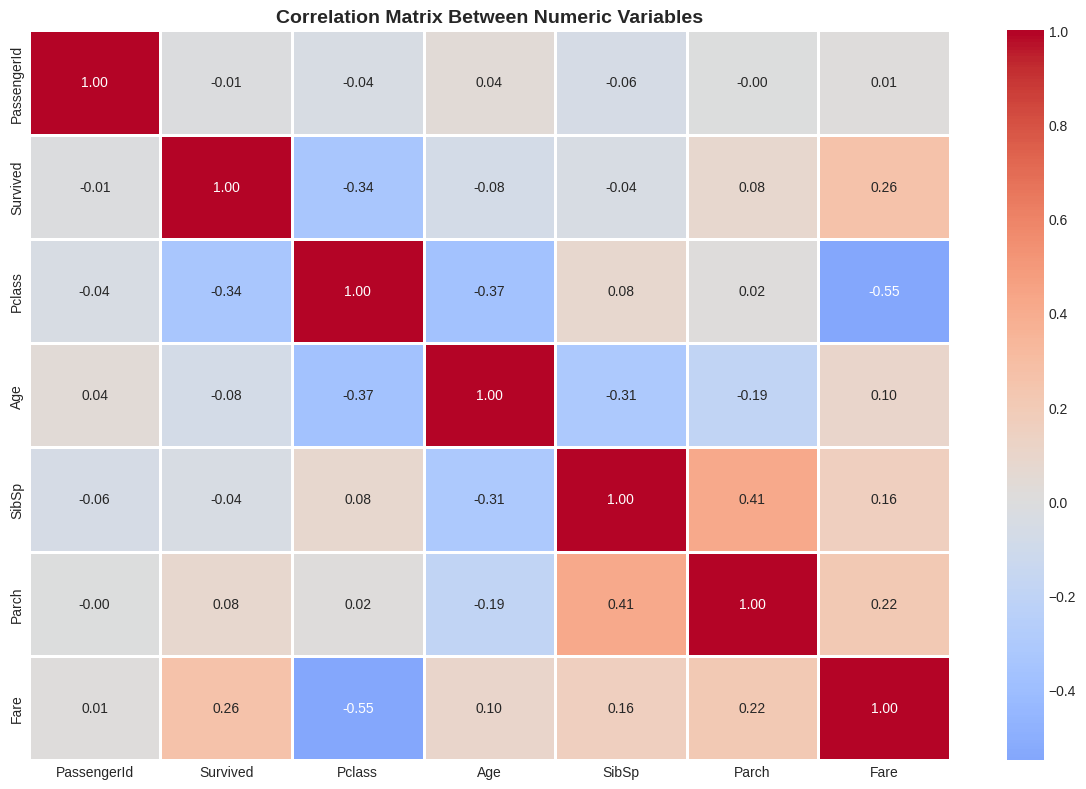


Factors strongly correlated with Survived:
Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


In [6]:
# Correlation matrix
plt.figure(figsize=(12, 8))
# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=1)
plt.title('Correlation Matrix Between Numeric Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nFactors strongly correlated with Survived:")
if survived_col in correlation_matrix.columns:
    print(correlation_matrix[survived_col].sort_values(ascending=False))

In [7]:
# make copies to pre-process data
train_processed = train_df.copy()
test_processed = test_df.copy()

# normalize columns' title
train_processed.columns = train_processed.columns.str.lower()
test_processed.columns = test_processed.columns.str.lower()

In [8]:
# Handle missing values

# 1. Age - fill with median by Pclass and Sex
for dataset in [train_processed, test_processed]:
    if 'age' in dataset.columns:
        # Fill age by Pclass and Sex groups
        dataset['age'].fillna(dataset.groupby(['pclass', 'sex'])['age'].transform('median'), inplace=True)
        # If still missing, fill with overall median
        dataset['age'].fillna(dataset['age'].median(), inplace=True)

# 2. Embarked - fill with mode
for dataset in [train_processed, test_processed]:
    if 'embarked' in dataset.columns:
        dataset['embarked'].fillna(dataset['embarked'].mode()[0], inplace=True)

# 3. Fare - fill with median
for dataset in [train_processed, test_processed]:
    if 'fare' in dataset.columns:
        dataset['fare'].fillna(dataset['fare'].median(), inplace=True)

# 4. Cabin - create new feature: has cabin or not
for dataset in [train_processed, test_processed]:
    if 'cabin' in dataset.columns:
        dataset['has_cabin'] = dataset['cabin'].notna().astype(int)

print("✓ Missing values handled")
print("\nRemaining missing values:")
print(train_processed.isnull().sum()[train_processed.isnull().sum() > 0])

✓ Missing values handled

Remaining missing values:
cabin    687
dtype: int64


In [9]:
# Feature Engineering

# 1. Family Size
for dataset in [train_processed, test_processed]:
    if 'sibsp' in dataset.columns and 'parch' in dataset.columns:
        dataset['family_size'] = dataset['sibsp'] + dataset['parch'] + 1
        
        # Create IsAlone feature
        dataset['is_alone'] = (dataset['family_size'] == 1).astype(int)

# 2. Age groups
for dataset in [train_processed, test_processed]:
    if 'age' in dataset.columns:
        dataset['age_group'] = pd.cut(dataset['age'], 
                                       bins=[0, 12, 18, 35, 60, 100], 
                                       labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

# 3. Fare groups  
for dataset in [train_processed, test_processed]:
    if 'fare' in dataset.columns:
        dataset['fare_group'] = pd.qcut(dataset['fare'], 
                                         q=4, 
                                         labels=['Low', 'Medium', 'High', 'Very High'],
                                         duplicates='drop')

# 4. Title from Name
for dataset in [train_processed, test_processed]:
    if 'name' in dataset.columns:
        dataset['title'] = dataset['name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
        
        # Merge rare titles
        dataset['title'] = dataset['title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                      'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                                      'Jonkheer', 'Dona'], 'Rare')
        dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
        dataset['title'] = dataset['title'].replace('Ms', 'Miss')
        dataset['title'] = dataset['title'].replace('Mme', 'Mrs')

print("✓ New features created")
print("\nNew features:")
print("- family_size: Total number of family members")
print("- is_alone: Whether traveling alone")
print("- age_group: Age group")
print("- fare_group: Fare group")
print("- title: Title from name")
print("- has_cabin: Has cabin information or not")

✓ New features created

New features:
- family_size: Total number of family members
- is_alone: Whether traveling alone
- age_group: Age group
- fare_group: Fare group
- title: Title from name
- has_cabin: Has cabin information or not


In [10]:
# Encode categorical variables

# Label Encoding for binary variables
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for dataset in [train_processed, test_processed]:
    if 'sex' in dataset.columns:
        if 'sex' not in label_encoders:
            label_encoders['sex'] = LabelEncoder()
            label_encoders['sex'].fit(train_processed['sex'])
        dataset['sex'] = label_encoders['sex'].transform(dataset['sex'])

# One-Hot Encoding for categorical variables
categorical_features = []
if 'embarked' in train_processed.columns:
    categorical_features.append('embarked')
if 'title' in train_processed.columns:
    categorical_features.append('title')
if 'age_group' in train_processed.columns:
    categorical_features.append('age_group')
if 'fare_group' in train_processed.columns:
    categorical_features.append('fare_group')

# Apply one-hot encoding
for feature in categorical_features:
    # Get dummies
    train_dummies = pd.get_dummies(train_processed[feature], prefix=feature, drop_first=True)
    test_dummies = pd.get_dummies(test_processed[feature], prefix=feature, drop_first=True)
    
    # Ensure both train and test have the same columns
    for col in train_dummies.columns:
        if col not in test_dummies.columns:
            test_dummies[col] = 0
    for col in test_dummies.columns:
        if col not in train_dummies.columns:
            train_dummies[col] = 0
    
    # Add to dataset
    train_processed = pd.concat([train_processed, train_dummies], axis=1)
    test_processed = pd.concat([test_processed, test_dummies], axis=1)

print("✓ Categorical variables encoded")

✓ Categorical variables encoded


In [11]:
# Select features for model
feature_columns = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 
                   'family_size', 'is_alone', 'has_cabin']

# Add one-hot encoded columns
for col in train_processed.columns:
    if col.startswith(('embarked_', 'title_', 'age_group_', 'fare_group_')):
        feature_columns.append(col)

# Filter only columns that exist in both train and test
feature_columns = [col for col in feature_columns if col in train_processed.columns and col in test_processed.columns]

print("Selected features:")
print(feature_columns)
print(f"\nTotal number of features: {len(feature_columns)}")

Selected features:
['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'family_size', 'is_alone', 'has_cabin', 'embarked_Q', 'embarked_S', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_Rare', 'age_group_Teen', 'age_group_Adult', 'age_group_Middle', 'age_group_Senior', 'fare_group_Medium', 'fare_group_High', 'fare_group_Very High']

Total number of features: 22


In [12]:
# Prepare data for training
X = train_processed[feature_columns].fillna(0)
y = train_processed['survived']

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data dimensions:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\n✓ Data prepared and features scaled")

Data dimensions:
X_train: (712, 22)
X_val: (179, 22)
y_train: (712,)
y_val: (179,)

✓ Data prepared and features scaled


In [13]:
# Test multiple models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate each model
results = {}

print("=" * 70)
print("TRAINING AND EVALUATING MODELS")
print("=" * 70)

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 70)
    
    # Train model
    if name == 'SVM' or name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        train_pred = model.predict(X_train_scaled)
        val_pred = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
    
    # Calculate accuracy
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    # Cross-validation score
    if name == 'SVM' or name == 'Logistic Regression':
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    results[name] = {
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"Training Accuracy:   {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"CV Score:            {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\n" + "=" * 70)

TRAINING AND EVALUATING MODELS

Logistic Regression:
----------------------------------------------------------------------
Training Accuracy:   0.8315
Validation Accuracy: 0.8492
CV Score:            0.8147 (+/- 0.0240)

Decision Tree:
----------------------------------------------------------------------
Training Accuracy:   0.9874
Validation Accuracy: 0.7989
CV Score:            0.7585 (+/- 0.0344)

Random Forest:
----------------------------------------------------------------------
Training Accuracy:   0.9874
Validation Accuracy: 0.7877
CV Score:            0.7979 (+/- 0.0447)

Gradient Boosting:
----------------------------------------------------------------------
Training Accuracy:   0.9157
Validation Accuracy: 0.8101
CV Score:            0.8246 (+/- 0.0360)

SVM:
----------------------------------------------------------------------
Training Accuracy:   0.8525
Validation Accuracy: 0.8268
CV Score:            0.8132 (+/- 0.0096)



MODEL COMPARISON TABLE (DEFAULT PARAMETERS)


,train_accuracy,val_accuracy,cv_mean,cv_std
Logistic Regression,0.831461,0.849162,0.814675,0.024033
SVM,0.852528,0.826816,0.813198,0.009609
Gradient Boosting,0.915730,0.810056,0.824554,0.036011
Decision Tree,0.987360,0.798883,0.758525,0.034425
Random Forest,0.987360,0.787709,0.797882,0.044723


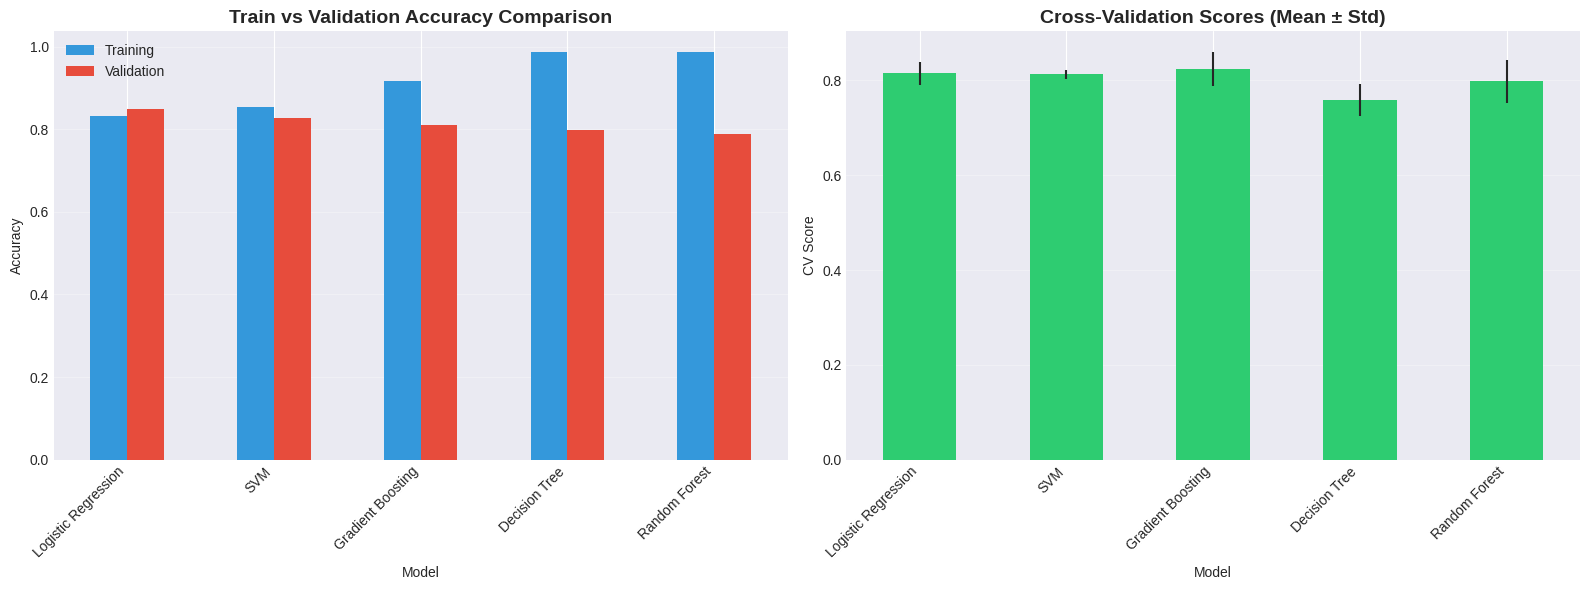


✓ Top 3 models (default params):
  1. Logistic Regression: Val=0.8492, CV=0.8147
  2. SVM: Val=0.8268, CV=0.8132
  3. Gradient Boosting: Val=0.8101, CV=0.8246


In [14]:
# Compare models
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('val_accuracy', ascending=False)

print("=" * 70)
print("MODEL COMPARISON TABLE (DEFAULT PARAMETERS)")
print("=" * 70)
display(results_df)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy comparison
results_df[['train_accuracy', 'val_accuracy']].plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Train vs Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Model')
axes[0].legend(['Training', 'Validation'])
axes[0].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: CV scores
results_df['cv_mean'].plot(kind='bar', ax=axes[1], color='#2ecc71', yerr=results_df['cv_std'])
axes[1].set_title('Cross-Validation Scores (Mean ± Std)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('CV Score')
axes[1].set_xlabel('Model')
axes[1].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Top 3 models (default params):")
for i, (name, row) in enumerate(results_df.head(3).iterrows(), 1):
    print(f"  {i}. {name}: Val={row['val_accuracy']:.4f}, CV={row['cv_mean']:.4f}")

In [15]:
# Hyperparameter Tuning for Random Forest
print("=" * 70)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("=" * 70)

from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution
rf_param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
rf_random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=rf_param_dist, 
    n_iter=40,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("\nSearching for best Random Forest parameters...")
rf_random_search.fit(X_train, y_train)

print(f"\n✓ Random Forest tuning completed")
print(f"Best parameters: {rf_random_search.best_params_}")
print(f"Best CV score: {rf_random_search.best_score_:.4f}")

# Evaluate tuned RF on validation set
rf_tuned = rf_random_search.best_estimator_
rf_tuned_pred = rf_tuned.predict(X_val)
rf_tuned_val_acc = accuracy_score(y_val, rf_tuned_pred)

print(f"\nRandom Forest Results:")
print(f"  Original Val Accuracy: {results['Random Forest']['val_accuracy']:.4f}")
print(f"  Tuned Val Accuracy:    {rf_tuned_val_acc:.4f}")
print(f"  Improvement:           {(rf_tuned_val_acc - results['Random Forest']['val_accuracy']):.4f}")

HYPERPARAMETER TUNING - RANDOM FOREST

Searching for best Random Forest parameters...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

✓ Random Forest tuning completed
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Best CV score: 0.8301

Random Forest Results:
  Original Val Accuracy: 0.7877
  Tuned Val Accuracy:    0.8045
  Improvement:           0.0168


In [16]:
# Hyperparameter Tuning for Logistic Regression
print("\n" + "=" * 70)
print("HYPERPARAMETER TUNING - LOGISTIC REGRESSION")
print("=" * 70)

# Define parameter distribution
lr_param_dist = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000, 2000]
}

lr_model = LogisticRegression(random_state=42)
lr_random_search = RandomizedSearchCV(
    lr_model,
    param_distributions=lr_param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("\nSearching for best Logistic Regression parameters...")
lr_random_search.fit(X_train_scaled, y_train)

print(f"\n✓ Logistic Regression tuning completed")
print(f"Best parameters: {lr_random_search.best_params_}")
print(f"Best CV score: {lr_random_search.best_score_:.4f}")

# Evaluate tuned LR on validation set
lr_tuned = lr_random_search.best_estimator_
lr_tuned_pred = lr_tuned.predict(X_val_scaled)
lr_tuned_val_acc = accuracy_score(y_val, lr_tuned_pred)

print(f"\nLogistic Regression Results:")
print(f"  Original Val Accuracy: {results['Logistic Regression']['val_accuracy']:.4f}")
print(f"  Tuned Val Accuracy:    {lr_tuned_val_acc:.4f}")
print(f"  Improvement:           {(lr_tuned_val_acc - results['Logistic Regression']['val_accuracy']):.4f}")


HYPERPARAMETER TUNING - LOGISTIC REGRESSION

Searching for best Logistic Regression parameters...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


✓ Logistic Regression tuning completed
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 2000, 'C': 0.5}
Best CV score: 0.8231

Logistic Regression Results:
  Original Val Accuracy: 0.8492
  Tuned Val Accuracy:    0.8492
  Improvement:           0.0000


In [17]:
# Hyperparameter Tuning for Logistic Regression
print("\n" + "=" * 70)
print("HYPERPARAMETER TUNING - LOGISTIC REGRESSION")
print("=" * 70)

# Define parameter distribution
lr_param_dist = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000, 2000]
}

lr_model = LogisticRegression(random_state=42)
lr_random_search = RandomizedSearchCV(
    lr_model,
    param_distributions=lr_param_dist,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("\nSearching for best Logistic Regression parameters...")
lr_random_search.fit(X_train_scaled, y_train)

print(f"\n✓ Logistic Regression tuning completed")
print(f"Best parameters: {lr_random_search.best_params_}")
print(f"Best CV score: {lr_random_search.best_score_:.4f}")

# Evaluate tuned LR on validation set
lr_tuned = lr_random_search.best_estimator_
lr_tuned_pred = lr_tuned.predict(X_val_scaled)
lr_tuned_val_acc = accuracy_score(y_val, lr_tuned_pred)

print(f"\nLogistic Regression Results:")
print(f"  Original Val Accuracy: {results['Logistic Regression']['val_accuracy']:.4f}")
print(f"  Tuned Val Accuracy:    {lr_tuned_val_acc:.4f}")
print(f"  Improvement:           {(lr_tuned_val_acc - results['Logistic Regression']['val_accuracy']):.4f}")


HYPERPARAMETER TUNING - LOGISTIC REGRESSION

Searching for best Logistic Regression parameters...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 


✓ Logistic Regression tuning completed
Best parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 2000, 'C': 0.5}
Best CV score: 0.8231

Logistic Regression Results:
  Original Val Accuracy: 0.8492
  Tuned Val Accuracy:    0.8492
  Improvement:           0.0000



FINAL MODEL COMPARISON: ORIGINAL VS TUNED
                                Validation Accuracy  CV Score
Logistic Regression (Tuned)                0.849162  0.823097
Logistic Regression (Original)             0.849162  0.814675
Random Forest (Tuned)                      0.804469  0.830129
Random Forest (Original)                   0.787709  0.797882


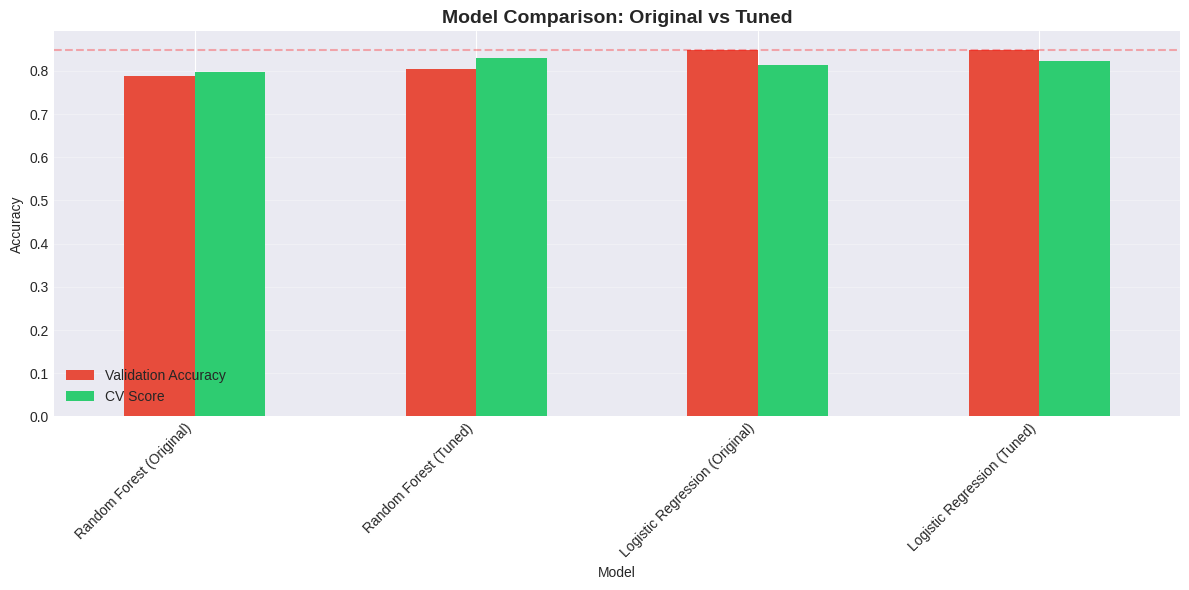


BEST MODEL SELECTED: LOGISTIC REGRESSION (ORIGINAL)
Validation Accuracy: 0.8492
CV Score: 0.8147
Uses scaled features: True

✓ Using original model (retraining on train set)


In [18]:
# Compare all models: Original vs Tuned
print("\n" + "=" * 70)
print("FINAL MODEL COMPARISON: ORIGINAL VS TUNED")
print("=" * 70)

comparison_data = {
    'Random Forest (Original)': {
        'val_accuracy': results['Random Forest']['val_accuracy'],
        'cv_score': results['Random Forest']['cv_mean'],
        'model': RandomForestClassifier(random_state=42, n_estimators=100),
        'use_scaled': False
    },
    'Random Forest (Tuned)': {
        'val_accuracy': rf_tuned_val_acc,
        'cv_score': rf_random_search.best_score_,
        'model': rf_tuned,
        'use_scaled': False
    },
    'Logistic Regression (Original)': {
        'val_accuracy': results['Logistic Regression']['val_accuracy'],
        'cv_score': results['Logistic Regression']['cv_mean'],
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'use_scaled': True
    },
    'Logistic Regression (Tuned)': {
        'val_accuracy': lr_tuned_val_acc,
        'cv_score': lr_random_search.best_score_,
        'model': lr_tuned,
        'use_scaled': True
    }
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    name: {'Validation Accuracy': data['val_accuracy'], 'CV Score': data['cv_score']}
    for name, data in comparison_data.items()
}).T

print(comparison_df.sort_values('Validation Accuracy', ascending=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
comparison_df.plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'])
ax.set_title('Model Comparison: Original vs Tuned', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.legend(['Validation Accuracy', 'CV Score'])
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=comparison_df['Validation Accuracy'].max(), color='r', linestyle='--', alpha=0.3, label='Best')
plt.tight_layout()
plt.show()

# Select the best model
best_config_name = comparison_df['Validation Accuracy'].idxmax()
best_config = comparison_data[best_config_name]

print(f"\n{'=' * 70}")
print(f"BEST MODEL SELECTED: {best_config_name.upper()}")
print(f"{'=' * 70}")
print(f"Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"CV Score: {best_config['cv_score']:.4f}")
print(f"Uses scaled features: {best_config['use_scaled']}")

# Set best model for later use
best_model = best_config['model']
best_model_name = best_config_name
use_scaled = best_config['use_scaled']

# Retrain best model on training data if needed
if 'Tuned' in best_config_name:
    print(f"\n✓ Using tuned model (already trained)")
else:
    print(f"\n✓ Using original model (retraining on train set)")
    if use_scaled:
        best_model.fit(X_train_scaled, y_train)
    else:
        best_model.fit(X_train, y_train)

In [19]:
# Train final model on entire training data (train + validation combined)
print("=" * 70)
print("TRAINING FINAL MODEL ON FULL DATASET")
print("=" * 70)
print(f"\nSelected Model: {best_model_name}")
print(f"Uses scaled features: {use_scaled}")

# Combine train and validation data
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

if use_scaled:
    # Fit scaler on full data
    X_full_scaled = scaler.fit_transform(X_full)
    
    # Train model on full scaled data
    if 'Tuned' in best_model_name:
        # If using tuned model, create new instance with best params
        final_model = type(best_model)(**best_model.get_params())
    else:
        final_model = type(best_model)(random_state=42, max_iter=1000)
    
    final_model.fit(X_full_scaled, y_full)
    print(f"\n✓ Trained {best_model_name} on {len(X_full)} samples (scaled)")
else:
    # Train model on full unscaled data
    if 'Tuned' in best_model_name:
        # If using tuned model, create new instance with best params
        final_model = type(best_model)(**best_model.get_params())
    else:
        final_model = type(best_model)(random_state=42, n_estimators=100)
    
    final_model.fit(X_full, y_full)
    print(f"\n✓ Trained {best_model_name} on {len(X_full)} samples")

TRAINING FINAL MODEL ON FULL DATASET

Selected Model: Logistic Regression (Original)
Uses scaled features: True

✓ Trained Logistic Regression (Original) on 891 samples (scaled)


In [20]:
# Make predictions on test set
print("\n" + "=" * 70)
print("MAKING PREDICTIONS ON TEST SET")
print("=" * 70)

# Prepare test data
X_test = test_processed[feature_columns].fillna(0)

if use_scaled:
    X_test_scaled = scaler.transform(X_test)
    test_predictions = final_model.predict(X_test_scaled)
else:
    test_predictions = final_model.predict(X_test)

print(f"\n✓ Created predictions for {len(test_predictions)} passengers")
print(f"\nPrediction Distribution:")
print(f"  Did not survive (0): {(test_predictions == 0).sum():3d} passengers ({(test_predictions == 0).sum() / len(test_predictions) * 100:.1f}%)")
print(f"  Survived (1):        {(test_predictions == 1).sum():3d} passengers ({(test_predictions == 1).sum() / len(test_predictions) * 100:.1f}%)")

# Expected survival rate from training data
train_survival_rate = y.mean() * 100
print(f"\nComparison with training data:")
print(f"  Training survival rate: {train_survival_rate:.1f}%")
print(f"  Test survival rate:     {(test_predictions == 1).sum() / len(test_predictions) * 100:.1f}%")


MAKING PREDICTIONS ON TEST SET

✓ Created predictions for 418 passengers

Prediction Distribution:
  Did not survive (0): 247 passengers (59.1%)
  Survived (1):        171 passengers (40.9%)

Comparison with training data:
  Training survival rate: 38.4%
  Test survival rate:     40.9%


In [21]:
# Create submission file
print("\n" + "=" * 70)
print("CREATING SUBMISSION FILE")
print("=" * 70)

if 'passengerid' in test_processed.columns:
    submission = pd.DataFrame({
        'PassengerId': test_processed['passengerid'].astype(int),
        'Survived': test_predictions.astype(int)
    })
    
    # Save submission file
    submission_filename = 'submission.csv'
    submission.to_csv(submission_filename, index=False)
    
    print(f"\n✓ Submission file saved: {submission_filename}")
    print(f"  Total predictions: {len(submission)}")
    print(f"  Model used: {best_model_name}")
    print(f"\nFirst 10 rows of submission:")
    print(submission.head(10))

else:
    print("\n⚠ Error: PassengerId column not found in test data")
    print("Creating predictions array instead:")
    print(test_predictions[:20])


CREATING SUBMISSION FILE

✓ Submission file saved: submission.csv
  Total predictions: 418
  Model used: Logistic Regression (Original)

First 10 rows of submission:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
